<a href="https://colab.research.google.com/github/hayatrajani/reinforcement-learning/blob/main/Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required Modules

In [ ]:
import numpy as np
from collections import defaultdict
from itertools import product
from operator import add
from random import choice
from skimage.draw import line
from matplotlib.patches import Rectangle, Polygon, Circle
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm import tqdm

%matplotlib inline
np.set_printoptions(linewidth=np.inf)

# Design the Grid World

![Racetrack](https://drive.google.com/uc?id=175ZPAWbbfp7XRRgfsOj__Xj2Qew_qPHm)

The agent always starts in one of the cells marked with $S$.

Its initial velocity is $(0,1)$, i.e. it would move one cell upward.

Actions are to increase or decrease its velocity components by one or to leave it unchanged.


* The agent can change both velocity components at the same time; it doesn't have to though!
* The agent doesn't teleport! It transitions through intermediate cells.  


Both velocity components are restricted to be non-negative and their sum must be at least $1$ and cannot exceed $5$.

The rewards are $-1$ for each step that the agent stays on the track, and $-10$ if the agent tries to drive off the track (enters a cell marked with $X$ or leaves the grid).


* The reward is assigned only for the whole transition i.e. -1 if you stay on track for the entire trajectory for that step.


The episode ends when the agent tries to drive off the track or when it crosses the finish line marked with $G$.

In [ ]:
gridSize = (18,14)

startCells = ((17,3), (17,4), (17,5), (17,6))
goalCells = ((1,13), (2,13), (3,13), (4,13), (5,13))
obstacles = (
    (0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9), (0,10), (0,11), (0,12), (0,13),
    (1,0), (0,1), (0,2), (0,3), (0,4),
    (2,0),
    (3,0),
    (4,0),
    (5,0),
    (6,0), (6,1), (6,11), (6,12), (6,13),
    (7,0), (7,1), (7,9), (7,10), (7,11), (7,12), (7,13),
    (8,0), (8,1), (8,8), (8,9), (8,10), (8,11), (8,12), (8,13),
    (9,0), (9,1), (9,2), (9,8), (9,9), (9,10), (9,11), (9,12), (9,13),
    (10,0), (10,1), (10,2), (10,8), (10,9), (10,10), (10,11), (10,12), (10,13),
    (11,0), (11,1), (11,2), (11,3), (11,8), (11,9), (11,10), (11,11), (11,12), (11,13),
    (12,0), (12,1), (12,2), (12,3), (12,8), (12,9), (12,10), (12,11), (12,12), (12,13),
    (13,0), (13,1), (13,2), (13,3), (13,7), (13,8), (13,9), (13,10), (13,11), (13,12), (13,13),
    (14,0), (14,1), (14,2), (14,3), (14,7), (14,8), (14,9), (14,10), (14,11), (14,12), (14,13),
    (15,0), (15,1), (15,2), (15,7), (15,8), (15,9), (15,10), (15,11), (15,12), (15,13),
    (16,0), (16,1), (16,2), (16,7), (16,8), (16,9), (16,10), (16,11), (16,12), (16,13),
    (17,0), (17,1), (17,2), (17,7), (17,8), (17,9), (17,10), (17,11), (17,12), (17,13),
)

onTrackReward = -1
offTrackReward = -10

minVelocity = 1
maxVelocity = 5

# increase or decrease velocity components by 1 or leave unchanged
# can change both velocity components together but doesn't have to
# i.e. all possible orderings of 2-tuples with element repetition
allActions = [a for a in product((-1,0,1),repeat=2)]
nActions = len(allActions)


class keydefaultdict(defaultdict):
    def __missing__(self, key):
        if self.default_factory is None:
            raise KeyError(key)
        else:
            val = self[key] = self.default_factory(key)
            return val

def initPolicy(state):
    # both velocity components restricted to be non-negative i.e. can't move backward or left
    # i.e. vx >= 0 and vy <= 0 since y-axis is inverted (numpy array)
    # and the (absolute) sum of the velocity components must be between 1 and 5 (inclusive)
    cell, velocity = state
    action_prob = np.ones(nActions)
    for i, action in enumerate(allActions):
        vy, vx = tuple(map(add,velocity,action))
        if vx < 0 or vy > 0 or not (minVelocity <= abs(vx)+abs(vy) <= maxVelocity):
            # actions that violate restrictions have no chance of occuring (probability=0)
            action_prob[i] = 0
    # all other actions are equiprobable
    action_prob *= 1/np.count_nonzero(action_prob)
    return action_prob


def initState():
    # begin at a random start cell with
    # initial velocity set to move up one cell
    # indexed (y,x) with y-axis inverted
    return (choice(startCells), (-1,0))


def step(state, action, deterministic=True):
    cell, velocity = state
    # compute new cell
    cell_ = tuple(map(add,cell,velocity))
    # when executing the velocity, the agent randomly moves one cell too far
    # either in the horizontal or vertical direction
    if not deterministic:
        cell_ = tuple(map(add,cell_,choice(((-1,0),(0,1)))))
    # compute new velocity
    velocity = tuple(map(add,velocity,action))
    # reward if agent is on track through the entire transition
    reward = onTrackReward
    done = False
    # check transition through intermediate cells
    for c in zip(*line(*cell,*cell_)):
        # end episode if agent passes through goal state
        if c in goalCells:
            done = True
            break
        # end episode with penalty if agent tries to leave the track
        elif not (0 <= c[0] < gridSize[0] and 0 <= c[1] < gridSize[1]) or c in obstacles:
            reward = offTrackReward
            done = True
            break
    return ((cell_, velocity), reward, done)


def policyEvaluation(policy, V = defaultdict(float), episodes=1000):
    returns = defaultdict(list)
    # repeat for each episode
    for _ in tqdm(range(episodes)):
        # starting from an initial state
        state = initState()
        # generate an episode following the given policy
        episode_rewards = []
        episode_states = dict()
        index = 0
        while True:
            # get possible actions from the current state
            # illegal actions have zero probability
            # legal actions are equiprobable by default
            action_prob = policy[state]
            # randomly choose a possible action
            action = allActions[np.random.choice(range(nActions),p=action_prob)]
            # observe the next state and reward
            nextState, reward, done = step(state, action)
            episode_rewards.append(reward)
            # maintain a map of (unique) states visited in the episode
            # and the corresponding indices of their first occurence
            _ = episode_states.setdefault(state,index)
            if done:
                break
            state = nextState
            index += 1
        # repeat for each state visited in the episode
        for state, index in episode_states.items():
            # return following the first occurence of the state
            returns[state].append(sum(episode_rewards[index:]))
            # average returns following first visits to the state thus far
            V[state] = sum(returns[state])/len(returns[state])
    return V


def onPolicyControl(Q = defaultdict(lambda: np.zeros(nActions)-np.inf),
                    episodes=1000, epsilon=0.1, deterministic=True):
    policy = keydefaultdict(initPolicy)
    returns = defaultdict(list)
    # repeat for each episode
    for _ in tqdm(range(episodes)):
        # starting from an initial state
        state = initState()
        # generate an episode following the given policy
        episode_rewards = []
        episode_states = set()
        episode_state_action = dict()
        index = 0
        while True:
            # get possible actions from the current state
            # illegal actions have zero probability
            action_prob = policy[state]
            # choose an action
            action_id = np.random.choice(range(nActions),p=action_prob)
            # observe the next state and reward
            nextState, reward, done = step(state, allActions[action_id], deterministic)
            episode_rewards.append(reward)
            # maintain a set of (unique) states visited in the episode
            episode_states.add(state)
            # maintain a map of (unique) state action pairs visited in the episode
            # and the corresponding indices of their first occurence
            _ = episode_state_action.setdefault((state,action_id), index)
            if done:
                break
            state = nextState
            index += 1
        # repeat for each state action pair visited in the episode
        for state_action, index in episode_state_action.items():
            # return following the first occurence of the state
            returns[state_action].append(sum(episode_rewards[index:]))
            # average returns following first visits to the state thus far
            state, action_id = state_action
            Q[state][action_id] = sum(returns[state_action])/len(returns[state_action])
        # for each state in the episode update the policy
        for state in episode_states:
            # choose the best possible action while randomly breaking ties
            best_action_id = np.random.choice(np.where(Q[state]==Q[state].max())[0])
            # update all legal action probabilities as per epsilon soft policy
            nzActions = np.count_nonzero(policy[state])
            for action_id in range(nActions):
                if policy[state][action_id] != 0:
                    policy[state][action_id] = epsilon/nzActions
            policy[state][best_action_id] += 1-epsilon
    return policy


def plotPolicy(policy, deterministic=True):
    fig, axs = plt.subplots(2,2,figsize=(gridSize[1],gridSize[0]))
    for ax, startCell in zip(axs.flat, startCells):
        ax.axis([0,gridSize[1],0,gridSize[0]])
        ax.set_xticks(range(gridSize[1]))
        ax.set_yticks(range(gridSize[0]))
        ax.grid(True, color='k', linewidth=1.5)
        ax.set_aspect(1)
        ax.invert_yaxis()
        ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none')
        ax.set_xticklabels([])
        ax.xaxis.set_ticks_position('none')
        for cell in startCells:
            ax.add_patch(Rectangle((cell[1],cell[0]),1,1,color='dodgerblue'))
        for cell in goalCells:
            ax.add_patch(Rectangle((cell[1],cell[0]),1,1,color='springgreen'))
        for cell in obstacles:
            ax.add_patch(Rectangle((cell[1],cell[0]),1,1,color='orangered'))
        state = (startCell, (-1,0))
        cells = [startCell]
        trajectory = []
        while True:
            action = allActions[np.argmax(policy[state])]
            nextState, _, done = step(state, action, deterministic)
            cells.append(nextState[0])
            trajectory.extend(zip(*line(*state[0],*nextState[0])))
            state = nextState
            if done:
                break
        for y,x in cells[:-1]:
            ax.add_patch(Circle((x+0.5,y+0.5), radius=0.15, fill=True, color='darkviolet'))
        trajectory = [(x+0.5,y+0.5) for y,x in trajectory]
        ax.add_patch(Polygon(trajectory[:-1], closed=None, fill=None, edgecolor='darkviolet', linewidth=2.5))
        ax.arrow(trajectory[-2][0],trajectory[-2][1], trajectory[-1][0]-trajectory[-2][0],trajectory[-1][1]-trajectory[-2][1],
                head_width=0.4, head_length=0.2, length_includes_head=True,
                fill=True, color='darkviolet', linewidth=2.5)
        ax.set_title('Start Cell: '+', '.join(str(c) for c in startCell), fontsize=18)
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    plt.show()

# Task 4.1

Compute V(s) for each grid cell using Monte Carlo Policy Evaluation for 1000 episodes of a policy that uniformly chooses one of the available actions.

In [ ]:
policy = keydefaultdict(initPolicy)
V = policyEvaluation(policy)
pprint(V)

# Task 4.2

Compute the optimal policy using on-policy Monte Carlo control.

Visualize the resulting trajectories for all start states S.

100%|██████████| 1000/1000 [00:00<00:00, 1120.90it/s]


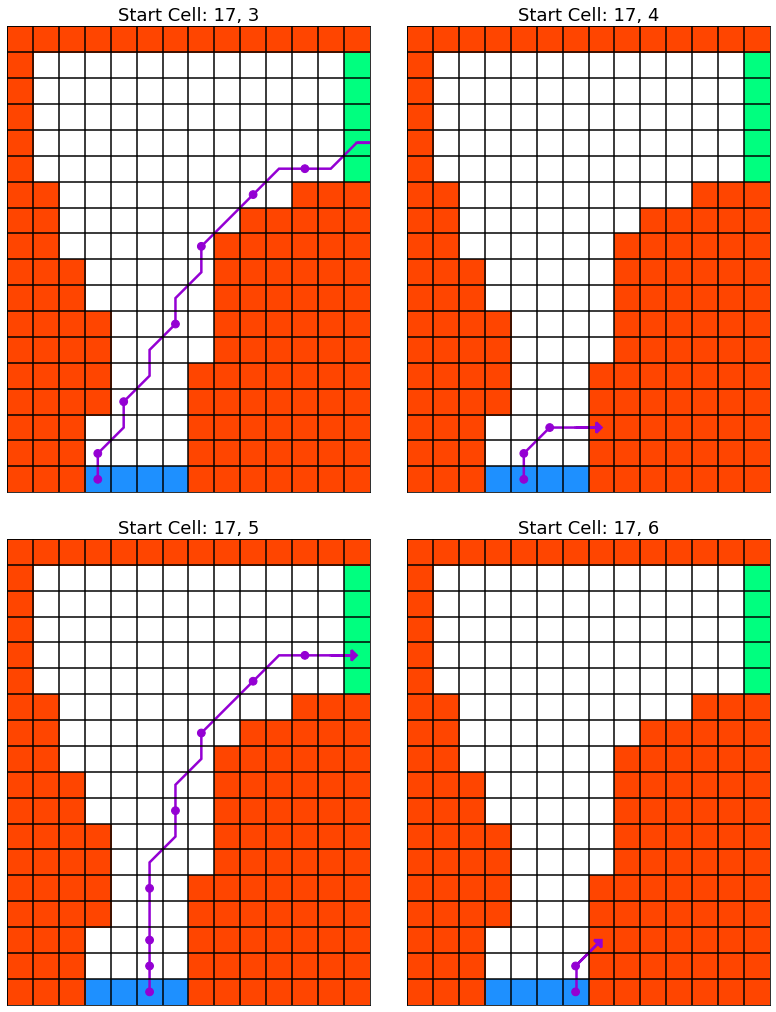

In [ ]:
learnedPolicy = onPolicyControl(deterministic=True)
print()
plotPolicy(learnedPolicy)

# Task 4.3

When executing the velocity, the agent moves randomly one cell too far in either the horizontal or the vertical direction.

Again, compute the optimal policy using on-policy Monte Carlo control.

Visualize the resulting trajectories for all start states S.

100%|██████████| 10000/10000 [00:06<00:00, 1477.36it/s]


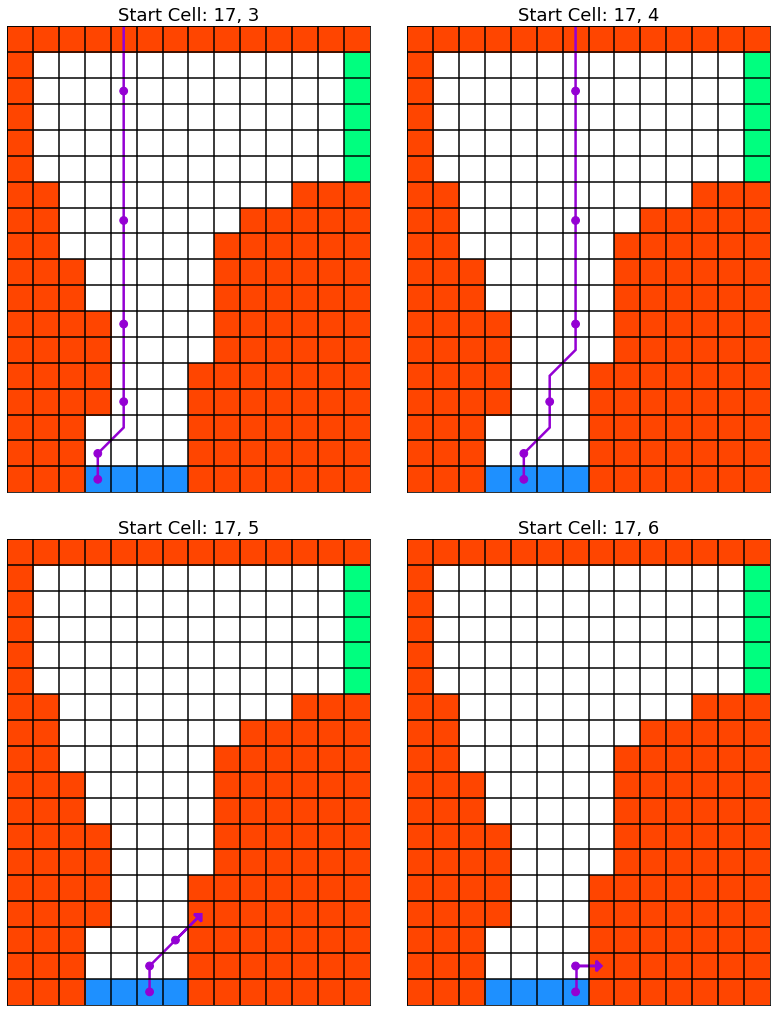

In [ ]:
learnedPolicy = onPolicyControl(deterministic=False, episodes=10000)
print()
plotPolicy(learnedPolicy)